# Preliminaries

This file contains the definition of the "GameState" class, which is the main driver of the code for the Eco/Farming simulator 

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Round Length Info

I need to know how long it takes for the natural bloons to send in each round

In [7]:
filepath = r"C:\Users\bmost\OneDrive\Documents\BTD Battles 2\nat_send_lengths.csv"
file = pd.read_csv(filepath)
nat_send_lens = list(file['Nat Send Len'])

I also need max stall times

In [8]:
filepath = r"C:\Users\bmost\OneDrive\Documents\BTD Battles 2\round_start_data.csv"
csv = pd.read_csv(filepath)
round_starts_stall = list(csv['Round Start (Stall)'])

max_stall_times = []
for i in range(len(round_starts_stall)-1):
    max_stall_times.append((round_starts_stall[i+1] - round_starts_stall[i]) - nat_send_lens[i])
    
print(max_stall_times)

[4, 11, 14, 15, 18, 21, 16, 23, 14, 20, 18, 17, 21, 13, 17, 26, 12, 14, 13, 15, 32, 17, 14, 17, 16, 28, 29, 23, 24, 19, 68]


In [282]:
#The formatting of the tuples is (eco_cost, eco_gain)
eco_send_info = {
    'Zero': (0,0),
    'Grouped Reds': (150,6.75),
    'Spaced Blues': (0,0),
    'Grouped Blues': (240,10),
    'Spaced Greens': (0,0),
    'Grouped Greens': (525,21),
    'Spaced Yellows': (125.28,6.264),
    'Grouped Yellows': (1000,40),
    'Spaced Pinks': (186.667,9.333),
    'Grouped Pinks': (0,0),
    'Spaced Whites': (214.2,10.71),
    'Grouped Whites': (0,0),
    'Spaced Blacks': (264,12.8),
    'Grouped Blacks': (1406.25,56.25),
    'Spaced Purples': (262.5,12.375),
    'Grouped Purples': (0,0),
    'Spaced Zebras': (0,0),
    'Grouped Zebras': (0,0),
    'Spaced Leads': (0,0),
    'Grouped Leads': (0,0),
    'Spaced Rainbows': (0,0),
    'Grouped Rainbows': (0,0),
    'Spaced Ceramics': (0,0),
    'Tight Ceramics': (0,0),
}

In [131]:
def dprint(phr, act = False):
    if act == True:
        print(phr)

# Game State Class

The game state class 

In [277]:
class GameState():
    def __init__(self, initial_state):
        
        ###########################
        #PART 1: INITIAL PARAMETERS
        ###########################
        
        #Set to true to print debug statements
        self.debug = initial_state.get('Debug')
        
        #Initial cash and eco
        self.cash = initial_state.get('Cash')
        self.eco = initial_state.get('Eco')
        
        #Eco send info
        eco_send = initial_state.get('Eco Send')
        self.eco_cost = eco_send_info[eco_send][0]
        self.eco_gain = eco_send_info[eco_send][1]
        
        #Alt eco info
        self.farms = initial_state.get('Farms')
        self.supply_drops = initial_state.get('Supply Drops')
        self.elite_sniper = initial_state.get('Elite Sniper') #If this is a number, then the number is the index of the elite sniper 
        
        #Stall factor info
        self.stall_factor = initial_state.get('Stall Factor')
        
        #Compute the time each round starts based on the given stall factor
        #Then, compute the current round we are on given the current game time
        
        val = 0
        self.round_starts = [0]
        for i in range(len(nat_send_lens)):
            round_len = nat_send_lens[i] + (1-self.stall_factor)*4 + self.stall_factor*max_stall_times[i]
            val += round_len
            self.round_starts.append(val)
            #print("Round %s is %s seconds long"%(str(i),round_len))
        
        
        #In most cases, the user will probably want to indicate a starting round rather than a starting time
        #If a starting round is given, compute the starting time based on the round starts
        #A round value of 15.5 means "halfway through round 15"
        if initial_state.get('Game Round') is not None:
            starting_round = initial_state.get('Game Round')
            self.current_time = self.computeTimeFromRound(starting_round)
        else:
            self.current_time = initial_state.get('Game Time')
        
        self.round = self.getRoundFromTime(self.current_time)
        
        #As the Game State evolves, I'll use these arrays to track how cash and eco have changed over time
        self.time_states = [self.current_time]
        self.cash_states = [self.cash] 
        self.eco_states = [self.eco]
        
        dprint("Initialized Game State!",self.debug)
        dprint("The current game round is %s"%(self.round),self.debug)
        dprint("The current game time is %s seconds"%(self.current_time),self.debug)
        dprint("The game round start times are given by %s"%(self.round_starts),self.debug)
            
        #######################
        # END OF INITIALIZATION
        #######################
        
    def getRoundFromTime(self, time):
        ind = 0
        while self.round_starts[ind] <= time:
            ind += 1
        dprint("getRoundFromTime mapped time %s to round %s"%(time,ind-1), self.debug)
        return ind - 1
        
    def viewCashEcoHistory(self):
        fig, ax = plt.subplots(2)
        fig.set_size_inches(6,9)
        ax[0].plot(self.time_states, self.cash_states, label = "Cash")
        ax[1].plot(self.time_states, self.eco_states, label = "Eco")
        
        #For easy reference, let's also mark on these graphs where the rounds start
        
        cash_min = min(self.cash_states)
        eco_min = min(self.eco_states)
        
        cash_max = max(self.cash_states)
        eco_max = max(self.eco_states)
        round_to_graph = self.getRoundFromTime(self.time_states[0]) + 1
        while self.round_starts[round_to_graph] <= self.time_states[-1]:
            dprint("Graphing round %s, which starts at time %s"%(str(round_to_graph),str(self.round_starts[round_to_graph])),self.debug)
            ax[0].plot([self.round_starts[round_to_graph], self.round_starts[round_to_graph]],[cash_min, cash_max], label = "R" + str(round_to_graph) + " start")
            ax[1].plot([self.round_starts[round_to_graph], self.round_starts[round_to_graph]],[eco_min, eco_max], label = "R" + str(round_to_graph) + " start")
            round_to_graph += 1
        
        ax[0].set_title("Cash vs Time")
        ax[1].set_title("Eco vs Time")
        
        ax[0].legend()
        ax[1].legend()
        
        fig.tight_layout()
     
    def computeTimeFromRound(self, round_val):
        frac_part = round_val - np.floor(round_val)
        return (1-frac_part)*self.round_starts[int(np.floor(round_val))] + frac_part*self.round_starts[int(np.ceil(round_val))]
    
    def changeStallFactor(self,stall_factor):
        #Modifies the stall factor mid-game by adjusting the length of remaining rounds
        val = self.round_starts[self.round]
        #Check whether the current round should have its stall time modified or not
        
        if val < self.round_starts[self.round] + nat_send_lens[self.round]:
            #Yes, the current round should have its stall time modified
            start_ind = self.round
        else:
            #No, the current round should not have its stall time modified
            start_ind = self.round+1
            val = self.round_starts[start_ind]
        
        for i in range(start_ind, len(nat_send_lens)-1):
            #print("Trying index %s"%(str(i)))
            val += nat_send_lens[i] + (1-stall_factor)*4 + stall_factor*max_stall_times[i]
            self.round_starts[i+1] = val
        
        dprint("Modified stall factor!",self.debug)
        dprint("The new round times are %s"%(self.round_starts),self.debug)
        dprint("The current game round is %s"%(self.round),self.debug)
        dprint("The current game time is %s seconds"%(self.current_time),self.debug)
        dprint("The next round starts at time %s"%(self.round_starts[self.round+1]),self.debug)
    
    def changeEcoSend(self,send_name):
        self.eco_cost = eco_send_info[send_name][0]
        self.eco_gain = eco_send_info[send_name][1]
    
    #def upgradeFarm(self, ind, path):
        #Tries to upgrade the farm belong to index ind based on the variable path
        #path = 0 -> Top path upgrade
        #path = 1 -> Middle path upgrade
        #path = 2 -> Bottom path upgrade
        
    def advanceGameState(self, target_time = None, target_round = None, granularity = 1):
        # Advance the game to the time target_time, 
        # computing the new money and eco amounts at target_time
        
        # If a target round is given, compute the target_time from that
        if target_round is not None:
            target_time = self.computeTimeFromRound(target_round)
        
        ####################################
        #PART 1: COMPUTATION OF PAYOUT TIMES
        ####################################
        
        #Entries in payout_times take the format (time, source)
        payout_times = []
        
        #First, let's identify payouts from eco
        eco_time = 6*(np.floor(self.current_time/6)+1)
        while eco_time <= target_time:
            payout_times.append((eco_time,'eco'))
            eco_time += 6

        #Next, let's do supply drops
        if self.supply_drops is not None:
            for i in range(len(self.supply_drops)):
                supply_drop  = self.supply_drops[i]
                if i == self.elite_sniper:
                    payout_source = 'elite sniper'
                else:
                    payout_source = 'supply drop'

                #Determine the earliest supply drop that could occur within the interval of interest (self.current_time,target_time]
                drop_index = max(1,np.ceil(1 + (self.current_time - supply_drop - 20)/40))
                supply_drop_time = supply_drop + 20 + 40*(drop_index-1)
                while supply_drop_time <= target_time:
                    payout_times.append((supply_drop_time,payout_source))
                    supply_drop_time += 40
            
        #Next, let's do farms!
        if self.farms is not None:
            for farm in self.farms:
                self.inc = 0
                self.flag = False
                while self.flag == False:
                    for i in range(farm.payout_frequency):
                        farm_time = self.round_starts[self.round + self.inc] + i*nat_send_lens[self.round + self.inc]/farm.payout_frequency
                        #TODO: If the farm is a MWS, account for the start-of-round bonus
                        if farm_time <= target_time and farm_time > self.current_time:
                            payout_times.append((farm_time,farm))
                        elif farm_time > target_time:
                            self.flag = True
                            break
                    self.inc += 1
                    
        #Finally, let us introduce something called a "tracer" payout
        #These are payouts of zero which are added to the payout table solely for the purpose of creating
        #a "finer" graph of the history of cash and eco. The frequency of tracer payouts is controlled by the parameter "granularity"
        
        if granularity is not None:
            time = self.current_time
            while time <= target_time:
                payout_times.append((time,'tracer'))
                time += granularity
                
        
        #Sort the payout times by the order they occur in
        payout_times = sorted(payout_times, key=lambda x: x[0]) 
        #dprint(payout_times,self.debug)
        
        ##############################
        #PART 2: COMPUTATION OF WEALTH
        ##############################
        
        time = self.current_time
        for payout in payout_times:
            #First, compute the impact of eco
            if self.eco_cost > 0:
                eco_time = min((payout[0] - time)*self.cash/self.eco_cost,payout[0] - time)
            else:
                eco_time = 0
            
            self.cash = self.cash - (eco_time/6)*self.eco_cost
            self.eco = self.eco + (eco_time/6)*self.eco_gain
                
            
            #Next, award the payout at the given time
            if type(payout[1]) is MonkeyFarm:
                self.cash += payout[1].payout_amount
                dprint("Awarded payment %s at time %s"%(payout[1].payout_amount,np.round(payout[0],2)),self.debug)
            elif payout[1] == 'eco':
                self.cash += self.eco
                dprint("Awarded payment %s at time %s"%(np.round(self.eco,2),np.round(payout[0],2)),self.debug)
            elif payout[1] == 'supply drop':
                self.cash += 2000
                dprint("Awarded payment 2000 at time %s"%(np.round(payout[0],2)),self.debug)
            elif payout[1] == 'elite sniper':
                self.cash += 5000
                dprint("Awarded payment 5000 at time %s"%(np.round(payout[0],2)),self.debug)
            #There is no need to modify the cash and eco for tracer payments
                
            
            #print("New cash and eco is (%s,%s)"%(np.round(self.cash,2), np.round(self.eco,2)))
            self.time_states.append(payout[0])
            self.cash_states.append(self.cash)
            self.eco_states.append(self.eco)
            
            time = payout[0]
        
        #Finally, account for the loss in cash and gain in eco from the final payment to the target_time
        if self.eco_cost > 0:
            eco_time = min((target_time - time)*self.cash/self.eco_cost,target_time - time)
        else:
            eco_time = 0
        
        self.cash = self.cash - (eco_time/6)*self.eco_cost
        self.eco = self.eco + (eco_time/6)*self.eco_gain
                
        self.time_states.append(target_time)
        self.cash_states.append(self.cash)
        self.eco_states.append(self.eco)
            
        ####################################
        #PART 3: UPDATE GAME TIME PARAMETERS
        ####################################
        
        #Determine the round we are in now
        self.current_time = target_time
        while self.round_starts[self.round] <= self.current_time:
            self.round += 1
        self.round -= 1
        dprint("Advanced game state to round " + str(self.round),self.debug)
        dprint("The current time is " + str(self.current_time),self.debug)
        dprint("The next round starts at time " + str(self.round_starts[self.round+1]),self.debug)
        
        

In [278]:
class MonkeyFarm():
    def __init__(self, initial_state):
        self.upgrades = initial_state.get('Upgrades')
        
        self.updateParameters(self.upgrades)
        self.purchase_time = initial_state.get('Purchase Time')
        self.payout_amount = initial_state.get('Payout Amount')
        self.payout_frequency = initial_state.get('Payout Frequency')
        
        self.BRF_buff = False
    
    def updateParameters(self, upgrades):
        #This is just a *really* long if-then statement
        if upgrades == [0,0,0]: #TOP PATH FARMS, NO CROSSPATH
            self.payout_amount = 40
            self.payout_frequency = 3
        elif upgrades == [1,0,0]:
            self.payout_amount = 40
            self.payout_frequency = 5
        elif upgrades == [2,0,0]:
            self.payout_amount = 40
            self.payout_frequency = 7
        elif upgrades == [3,0,0]:
            self.payout_amount = 40
            self.payout_frequency = 16
        elif upgrades == [4,0,0]:
            self.payout_amount = 600
            self.payout_frequency = 5
        elif upgrades == [5,0,0]:
            self.payout_amount = 3000
            self.payout_frequency = 5
            self.BRF_buff = True
        elif upgrades == [0,2,0]: #TOP PATH FARMS, MIDDLE CROSSPATH
            self.payout_amount = 50
            self.payout_frequency = 3
        elif upgrades == [1,2,0]:
            self.payout_amount = 50
            self.payout_frequency = 5
        elif upgrades == [2,2,0]:
            self.payout_amount = 50
            self.payout_frequency = 7
        elif upgrades == [3,2,0]:
            self.payout_amount = 50
            self.payout_frequency = 16
        elif upgrades == [4,2,0]:
            self.payout_amount = 750
            self.payout_frequency = 5
        elif upgrades == [5,2,0]:
            self.payout_amount = 3750
            self.payout_frequency = 5
            self.BRF_buff = True
            

# Example Use Cases

## Case 1: Starting with Grouped Eco

We demonstrate the progression of cash and eco from the start of the game to the end of round 4 when the player commits to the usual flow chart of grouped eco:
1. Grouped Reds R1-2
2. Grouped Blues R3-4

We then compare it to the following alternative flow chart:
1. Grouped Reds R1-2
2. Grouped Blues R3
3. Spaced Pinks R4

To begin, let's initialize the GameState Class:

getRoundFromTime mapped time 0.0 to round 0
Initialized Game State!
The current game round is 0
The current game time is 0.0 seconds
The game round start times are given by [0, 6.0, 28.75, 51.25, 75.0, 104.5, 132.75, 155.75, 180.5, 201.0, 222.0, 232.5, 246.75, 263.0, 282.25, 294.5, 312.0, 344.0, 382.5, 407.75, 443.5, 456.5, 472.75, 502.25, 514.5, 574.5, 613.5, 643.75, 669.5, 694.5, 741.25, 763.25]
Awarded payment 250.0 at time 6.0
Advanced game state to round 1
The current time is 6.0
The next round starts at time 28.75
Awarded payment 256.75 at time 12.0
Awarded payment 263.5 at time 18.0
Awarded payment 270.25 at time 24.0
Awarded payment 277.0 at time 30.0
Awarded payment 283.75 at time 36.0
Awarded payment 290.5 at time 42.0
Awarded payment 297.25 at time 48.0
Advanced game state to round 3
The current time is 51.25
The next round starts at time 75.0
Awarded payment 303.78 at time 54.0
Awarded payment 310.04 at time 60.0
Awarded payment 316.31 at time 66.0
Awarded payment 322.57 at

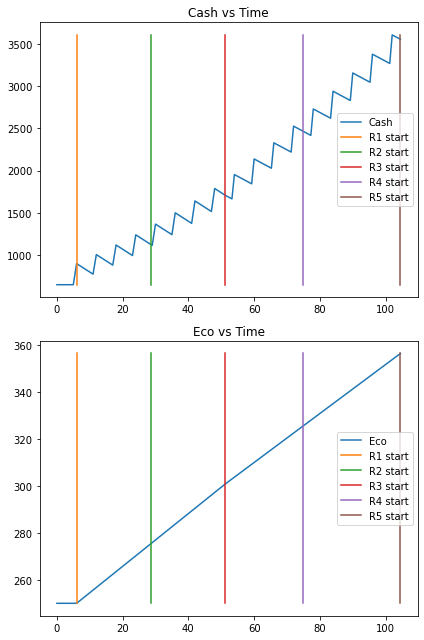

In [287]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.25,
    'Game Round': 0,
    'Debug': True
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(target_round=1)
game_state.changeEcoSend('Grouped Reds')
game_state.advanceGameState(target_round=3)
game_state.changeEcoSend('Spaced Yellows')
game_state.advanceGameState(target_round=5)
game_state.viewCashEcoHistory()
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))

Current Cash and Eco: (3292.0,372.0)


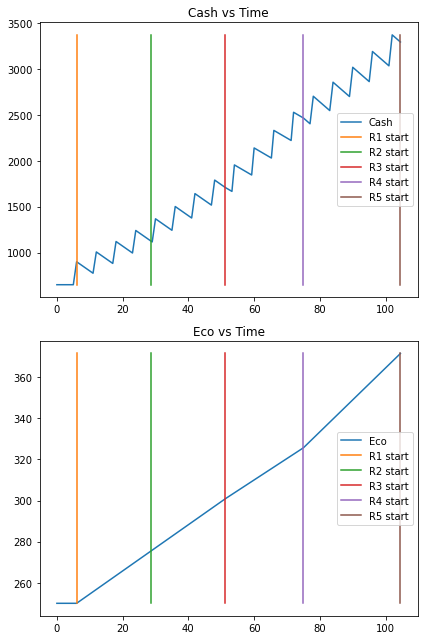

In [283]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.25,
    'Game Round': 0,
    'Debug': False
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(target_round=1)
game_state.changeEcoSend('Grouped Reds')
game_state.advanceGameState(target_round=3)
game_state.changeEcoSend('Spaced Yellows')
game_state.advanceGameState(target_round=4)
game_state.changeEcoSend('Spaced Pinks')
game_state.advanceGameState(target_round=5)
game_state.viewCashEcoHistory()
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))

## Case 2: Tigerz's Experiment

Current Cash and Eco: (3293.0,817.0)


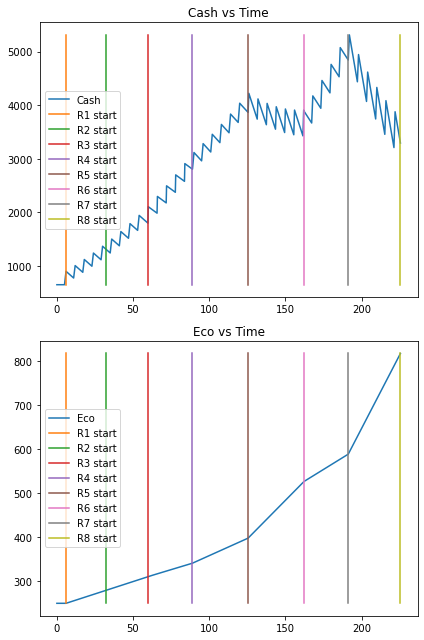

In [288]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.75,
    'Game Round': 0,
    'Debug': False
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(target_round=1)

game_state.changeEcoSend('Grouped Reds')
game_state.advanceGameState(target_round=3)

game_state.changeEcoSend('Spaced Yellows')
game_state.advanceGameState(target_round=4)

game_state.changeEcoSend('Spaced Pinks')
game_state.advanceGameState(target_round=5)

game_state.changeEcoSend('Grouped Greens')
game_state.advanceGameState(target_round=6)

game_state.changeEcoSend('Spaced Blacks')
game_state.advanceGameState(target_round=7)

game_state.changeEcoSend('Grouped Yellows')
game_state.advanceGameState(target_round=8)



game_state.viewCashEcoHistory()
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))

Current Cash and Eco: (3191.0,835.0)


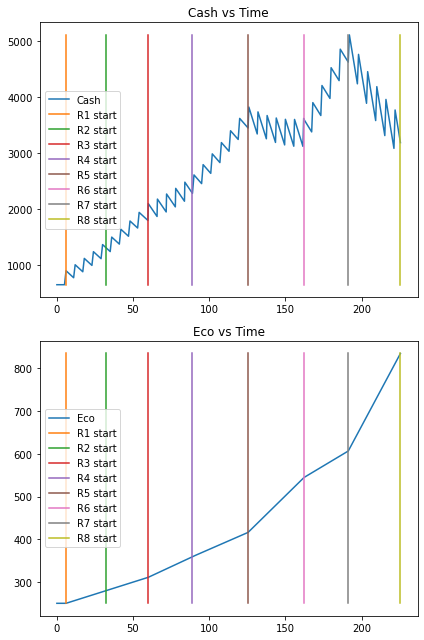

In [289]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.75,
    'Game Round': 0,
    'Debug': False
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(target_round=1)

game_state.changeEcoSend('Grouped Reds')
game_state.advanceGameState(target_round=3)

game_state.changeEcoSend('Grouped Blues')
game_state.advanceGameState(target_round=4)

game_state.changeEcoSend('Spaced Pinks')
game_state.advanceGameState(target_round=5)

game_state.changeEcoSend('Grouped Greens')
game_state.advanceGameState(target_round=6)

game_state.changeEcoSend('Spaced Blacks')
game_state.advanceGameState(target_round=7)

game_state.changeEcoSend('Grouped Yellows')
game_state.advanceGameState(target_round=8)



game_state.viewCashEcoHistory()
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))

## Case 2: The Farm Flowchart

We now consider a spaced eco flowchart starting from round 1 and extending until the player affords a 320 farm (~R8). Generally speaking, the player assumes the following eco flowchart:
1. Grouped Reds R1
2. Spaced Greens R2
3. Spaced Yellows R3
4. Spaced Pinks R4-5
5. Spaced Blacks R6-???

Meanwhile, the player adopts the following farm flowchart:
1. Buy 000 farm
2. Upgrade to 100 farm
3. Upgrade to 200 farm
4. Upgrade to 300 farm
5. Upgrade to 320 farm

getRoundFromTime mapped time 344.0 to round 17
Initialized Game State!
The current game round is 17
The current game time is 344.0 seconds
The game round start times are given by [0, 6.0, 28.75, 51.25, 75.0, 104.5, 132.75, 155.75, 180.5, 201.0, 222.0, 232.5, 246.75, 263.0, 282.25, 294.5, 312.0, 344.0, 382.5, 407.75, 443.5, 456.5, 472.75, 502.25, 514.5, 574.5, 613.5, 643.75, 669.5, 694.5, 741.25, 763.25]
Awarded payment 40 at time 346.0
Awarded payment 1527.2 at time 348.0
Awarded payment 40 at time 348.0
Awarded payment 40 at time 350.0
Awarded payment 40 at time 352.0
Awarded payment 1581.63 at time 354.0
Awarded payment 40 at time 354.0
Awarded payment 40 at time 356.0
Awarded payment 40 at time 358.0
Awarded payment 1637.88 at time 360.0
Awarded payment 40 at time 360.0
Awarded payment 40 at time 362.0
Awarded payment 40 at time 364.0
Awarded payment 1694.13 at time 366.0
Awarded payment 40 at time 366.0
Awarded payment 40 at time 368.0
Awarded payment 40 at time 370.0
Awarded payme

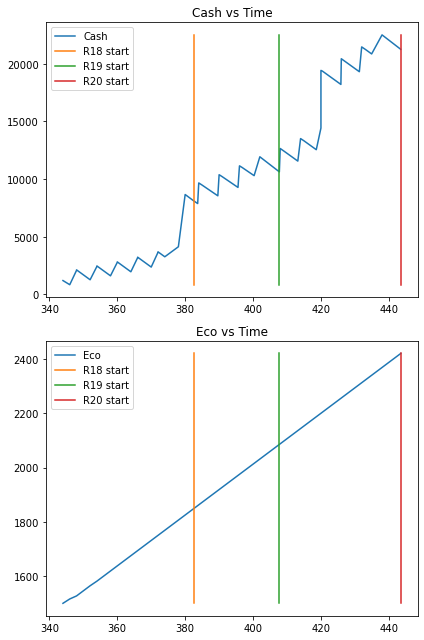

In [210]:
initial_state_farm = {
    'Purhcase Time': 180,
    'Payout Amount': 40,
    'Payout Frequency': 16
}

r7plant = MonkeyFarm(initial_state_farm)

initial_state_game = {
    'Cash': 1200,
    'Eco': 1500,
    'Eco Send': 'Grouped Blacks',
    'Farms': [r7plant],
    'Supply Drops': [280],
    'Elite Sniper': 0,
    'Stall Factor': 0.25,
    'Game Round': 17,
    'Debug': True
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(450, target_round = 20)
game_state.viewCashEcoHistory()